In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, MaxPool2D
from keras.datasets import fashion_mnist

from sklearn.manifold import TSNE

In [3]:
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()


In [4]:
SEED = 2020

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [5]:
x_valid, x_train = x_train_full[:-5000] / 255.0, x_train_full[-5000:] / 255.0
y_valid, y_train = y_train_full[:-5000], y_train_full[-5000:]
x_test = x_test/ 255.0

In [6]:
# x_train[0]


In [7]:
stacked_encoder = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(100, activation='selu'),
    Dense(30, activation='selu')
])


In [8]:
stacked_decoder = Sequential([
    Dense(100, activation='selu', input_shape=[30]),
    Dense(28 * 28, activation='sigmoid'),
    Reshape([28, 28])
])

In [9]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
stacked_ae = Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(keras.optimizers.SGD(lr=1.5), keras.losses.binary_crossentropy, [rounded_accuracy])

In [11]:
history = stacked_ae.fit(x_train, x_train, epochs=10, validation_data=(x_valid, x_valid))

Epoch 1/10
157/157 [==============================] - 2s 15ms/step - loss: 0.4621 - rounded_accuracy: 0.7809 - val_loss: 0.3734 - val_rounded_accuracy: 0.8572
Epoch 2/10
157/157 [==============================] - 2s 14ms/step - loss: 0.3646 - rounded_accuracy: 0.8654 - val_loss: 0.3589 - val_rounded_accuracy: 0.8761

In [12]:

# 재구성 시각화

In [13]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis("off")


In [14]:
def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(x_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))

    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(x_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images+image_index)
        plot_image(reconstructions[image_index])


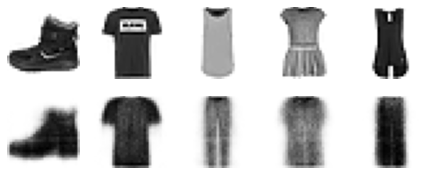

In [15]:
show_reconstructions(stacked_ae)

In [16]:
# 데이터셋 시각화

x_valid_compressed = stacked_encoder.predict(x_valid)
tsne = TSNE()
x_valid_2D = tsne.fit_transform(x_valid_compressed)

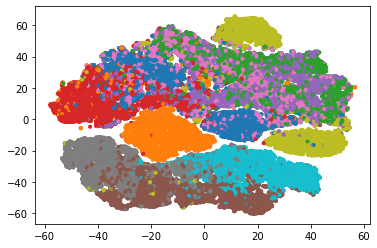

In [17]:
plt.scatter(x_valid_2D[:, 0], x_valid_2D[:, 1], c=y_valid, s=10, cmap='tab10' )


In [18]:
keras.backend.clear_session()

In [19]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias', initializer="zeros", shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)

    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)



In [20]:
dense_1 = Dense(100, activation='selu')
dense_2 = Dense(30, activation='selu')

tied_encoder = Sequential([
    Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

In [21]:
tied_decoder = Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    Reshape([28, 28])
    ])

In [22]:
tied_ae = Sequential([tied_encoder, tied_decoder])

In [23]:
tied_ae.compile(keras.optimizers.SGD(lr=1.5), keras.losses.binary_crossentropy, [rounded_accuracy])

In [24]:
history2 = tied_ae.fit(x_train, x_train, epochs=10, validation_data=(x_valid, x_valid))

Epoch 1/10
157/157 [==============================] - 2s 15ms/step - loss: 0.4522 - rounded_accuracy: 0.7850 - val_loss: 0.3571 - val_rounded_accuracy: 0.8679
Epoch 2/10
157/157 [==============================] - 2s 15ms/step - loss: 0.3419 - rounded_accuracy: 0.8821 - val_loss: 0.3326 - val_rounded_accuracy: 0.8966

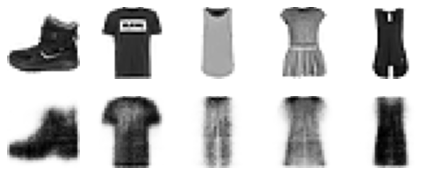

In [25]:
show_reconstructions(tied_ae)
plt.show()

### 합성곡 오토인코더

In [26]:
conv_encoder = Sequential([
    Reshape([28,28,1], input_shape=[28, 28]),
    Conv2D(16, kernel_size = 3, padding='same', activation='selu'),
    MaxPool2D(pool_size=2),
    Conv2D(32, kernel_size = 3, padding='same', activation='selu'),
    MaxPool2D(pool_size=2),
    Conv2D(64, kernel_size = 3, padding='same', activation='selu'),
    MaxPool2D(pool_size=2),
])

In [27]:
conv_decoder = Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size = 3, strides = 2, padding='valid', activation='selu', input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size = 3, strides = 2, activation='selu', padding='same'),
    keras.layers.Conv2DTranspose(1, kernel_size = 3, strides = 2, activation='selu', padding='same'),
    Reshape([28, 28])
])

In [28]:
conv_ae = Sequential([conv_encoder, conv_decoder])

In [29]:
conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history3 = conv_ae.fit(x_train, x_train, epochs=5,
                      validation_data=(x_valid, x_valid))

Epoch 1/5
157/157 [==============================] - 4s 25ms/step - loss: 10.7989 - rounded_accuracy: 0.3195 - val_loss: 10.8907 - val_rounded_accuracy: 0.3144

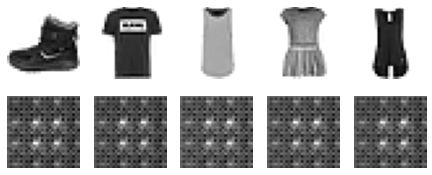

In [30]:
show_reconstructions(conv_ae)
plt.show()

In [31]:
# 순환 오토인코더

recurrent_encoder = Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
    keras.layers.LSTM(30)
])

In [32]:
recurrent_decoder = Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid'))
])



In [33]:
recurrent_ae = Sequential([recurrent_encoder, recurrent_decoder])

In [34]:
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history3 = recurrent_ae.fit(x_train, x_train, epochs=5,
                      validation_data=(x_valid, x_valid))

Epoch 1/5
157/157 [==============================] - 9s 57ms/step - loss: 0.5376 - rounded_accuracy: 0.7207 - val_loss: 0.4949 - val_rounded_accuracy: 0.7846

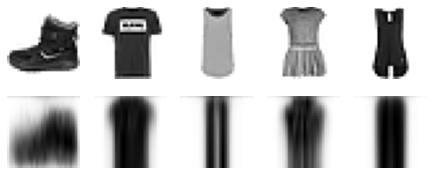

In [35]:
show_reconstructions(recurrent_ae)
plt.show()

In [36]:
#잡음 제거 오토인코더

dropout_encoder = Sequential([
    Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    Dense(100, activation='selu'),
    Dense(30, activation='selu')
])

In [37]:
dropout_decoder = Sequential([
    Dense(100, activation='selu', input_shape=[30]),
    Dense(28*28, activation='sigmoid'),
    Reshape([28, 28])
])

In [38]:
dropout_ae = Sequential([dropout_encoder, dropout_decoder])



In [39]:

dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history3 = dropout_ae.fit(x_train, x_train, epochs=5,
                      validation_data=(x_valid, x_valid))

Epoch 1/5
157/157 [==============================] - 3s 19ms/step - loss: 0.4963 - rounded_accuracy: 0.7486 - val_loss: 0.3970 - val_rounded_accuracy: 0.8447
Epoch 2/5
157/157 [==============================] - 2s 15ms/step - loss: 0.3833 - rounded_accuracy: 0.8475 - val_loss: 0.3721 - val_rounded_accuracy: 0.8624

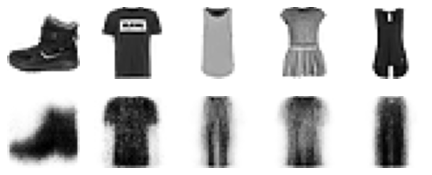

In [40]:
show_reconstructions(dropout_ae)
plt.show()


In [41]:
#희소 오토인코더

sparse_l1_encoder = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(100, activation='selu'),
    Dense(300, activation='sigmoid'),
    keras.layers.ActivityRegularization(l1=1e-3)
])

In [42]:
sparse_l1_decoder = Sequential([
    Dense(100, activation='selu', input_shape=[300]),
    Dense(28 * 28 , activation='sigmoid'),
    Reshape([28, 28])
])



In [43]:
sparse_le_ae = Sequential([sparse_l1_encoder, sparse_l1_decoder])

In [47]:
sparse_le_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history3 = sparse_le_ae.fit(x_train, x_train, epochs=20,
                      validation_data=(x_valid, x_valid))

Epoch 1/20
157/157 [==============================] - 4s 27ms/step - loss: 0.4078 - rounded_accuracy: 0.8333 - val_loss: 0.4002 - val_rounded_accuracy: 0.8407
Epoch 2/20
157/157 [==============================] - 3s 18ms/step - loss: 0.3982 - rounded_accuracy: 0.8425 - val_loss: 0.3932 - val_rounded_accuracy: 0.8490

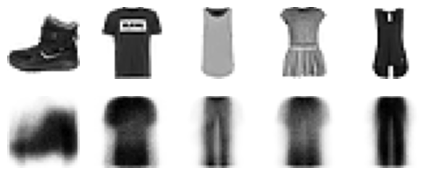

In [48]:
show_reconstructions(sparse_le_ae)
plt.show()

In [49]:
#KL 발산
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

In [70]:
class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def call(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (kl_divergence(self.target, mean_activities) +
                              kl_divergence(1. - self.target, 1. - mean_activities))

In [71]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)

In [72]:
sparse_kl_encoder = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(100, activation='selu'),
    Dense(300, activation='sigmoid', activity_regularizer=kld_reg)
])

AttributeError: 'float' object has no attribute 'dtype'

In [58]:
sparse_kl_decoder = Sequential([
    Dense(100, activation='selu', input_shape=([300])),
    Dense(28 * 28, activation='sigmoid'),
    Reshape([28, 28])
])

In [61]:
sparse_kl_ae = Sequential([sparse_kl_encoder, sparse_kl_decoder])

NameError: name 'sparse_kl_encoder' is not defined

In [56]:
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history3 = sparse_kl_ae.fit(x_train, x_train, epochs=20,
                      validation_data=(x_valid, x_valid))

NameError: name 'sparse_kl_ae' is not defined

In [ ]:
show_reconstructions(sparse_kl_ae)
plt.show()

AttributeError: 'float' object has no attribute 'dtype'